In [59]:
import os, sys
import numpy as np
import ants
import argparse
import shutil
import logging
import subprocess
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
from glob2 import glob

path_gbm = '/anvar/public_datasets/preproc_study/gbm/1_reg'
path_bgpd = '/anvar/public_datasets/preproc_study/bgpd/orig'
path_schw = '/anvar/public_datasets/preproc_study/schw/orig'

list_gbm = glob(path_gbm + '/**/CT1_SEG.nii.gz')
list_bgpd = glob(path_bgpd + '/**/mask_GTV_FLAIR.nii.gz')
list_schw = glob(path_schw + '/**/T1_SEG.nii.gz')

In [26]:
# checking for right labels
import ants

for img_path in tqdm(list_gbm):
    img_orig = ants.image_read(img_path)
    channels = np.unique(img_orig.numpy())[1:]
    if channels[0] != 1:
        print(img_path)
        print('weird channels', channels)
        result_arr = img_orig.numpy()
        result_arr[result_arr == channels[0]] = int(1)
        result_arr[result_arr == channels[1]] = int(2)
        result_arr[result_arr == channels[2]] = int(3)
        img_new = img_orig.new_image_like(result_arr)
        print(np.unique(img_new.numpy())[1:])
#         os.remove(img_path)
#         ants.image_write(img_new, img_path, ri=False);

 19%|█▊        | 19/102 [00:05<00:14,  5.69it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6661/CT1_SEG.nii.gz
weird channels [1.560928 4.682784 6.243712]
[1. 2. 3.]


 46%|████▌     | 47/102 [00:15<00:24,  2.25it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-14-1794/CT1_SEG.nii.gz
weird channels [2.5308914 5.061783  7.5926743]


 47%|████▋     | 48/102 [00:15<00:25,  2.09it/s]

[1. 2. 3.]


 58%|█████▊    | 59/102 [00:21<00:19,  2.21it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6657/CT1_SEG.nii.gz
weird channels [3.2803419 6.5606837 9.841025 ]
[1. 2. 3.]


 61%|██████    | 62/102 [00:22<00:12,  3.29it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6662/CT1_SEG.nii.gz
weird channels [1.8251526 3.6503053 5.475458 ]
[1. 2. 3.]


 70%|██████▉   | 71/102 [00:26<00:16,  1.87it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-4935/CT1_SEG.nii.gz
weird channels [1.4778999 2.9557998 4.4336996]
[1. 2. 3.]


 76%|███████▋  | 78/102 [00:28<00:05,  4.22it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6664/CT1_SEG.nii.gz
weird channels [1.8178266 3.6356533 5.45348  ]
[1. 2. 3.]
/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6663/CT1_SEG.nii.gz
weird channels [ 3.823199  7.646398 11.469597]
[1. 2. 3.]


 78%|███████▊  | 80/102 [00:28<00:04,  4.78it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-4934/CT1_SEG.nii.gz
weird channels [1.524298 3.048596 4.572894]
[1. 2. 3.]


 95%|█████████▌| 97/102 [00:38<00:02,  1.76it/s]

/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-76-6656/CT1_SEG.nii.gz
weird channels [1.9323565 3.864713  5.7970695]
[1. 2. 3.]


100%|██████████| 102/102 [00:39<00:00,  2.56it/s]


### Quality check:

In [39]:
base_dir = '/anvar/public_datasets/preproc_study/bgpd/4a_resamp/'
mask = 'mask_GTV_FLAIR.nii.gz'

for patient in tqdm(os.listdir(base_dir)):
    if not patient == 'logging.txt':
        for modality in ['T1.nii.gz','T2.nii.gz','FLAIR.nii.gz','CT1.nii.gz', mask]:
            img = ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/{}'.format(patient, modality))
            
            if modality == 'T1.nii.gz':
                t1_shape = np.shape(img.numpy())
                
            if modality == 'T2.nii.gz':
                t2_shape = np.shape(img.numpy())
                
            if modality == 'FLAIR.nii.gz':
                flair_shape = np.shape(img.numpy())
                
            # test for binary mask
            if modality == mask:
                # for 1 channel labels
                if len(np.unique(img.numpy())) > 2:
                    print(patient, np.unique(img.numpy()))
                mask_shape = np.shape(img.numpy())
            # test for nans    
            if not img.sum() > 0:
                print(patient, modality, 'Amount of nans:', np.shape(np.argwhere(np.isnan(img.numpy()))))
        
        # test for shapaes
        if (t1_shape != t2_shape)| (t1_shape != flair_shape) | (t1_shape != mask_shape):
            print(patient, ' t1', t1_shape, ' t2', t2_shape, 'flair', flair_shape, ' mask', mask_shape)

100%|██████████| 181/181 [05:52<00:00,  1.95s/it]


In [168]:
base_dir = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_1/'
predicate_dir = '/anvar/public_datasets/preproc_study/gbm/4a_resamp/'
mask = 'CT1_SEG.nii.gz'
label = [0,1,2,3]

def check_path(base_dir, predicate_dir, mask, label, check_pred = True):
    for patient in tqdm(os.listdir(base_dir)):
        if not patient == 'logging.txt':
            
            try:
                for modality in ['T1.nii.gz','T2.nii.gz','FLAIR.nii.gz','CT1.nii.gz', mask]:
                        img = ants.image_read(base_dir + '/{}/{}'.format(patient, modality))

                        if modality == 'T1.nii.gz':
                            t1_shape = np.shape(img.numpy())

                            #checking for T1 only, if the data remains unchanged
                            img_pred = ants.image_read(predicate_dir + '/{}/{}'.format(patient, modality))

                            if check_pred:
                                if np.allclose(img.numpy(),img_pred.numpy()):
                                    print('The sourse data and preprocessed are equal')

                        if modality == 'T2.nii.gz':
                            t2_shape = np.shape(img.numpy())

                        if modality == 'FLAIR.nii.gz':
                            flair_shape = np.shape(img.numpy())

                        # test for binary mask
                        if modality == mask:
                            # for 1 channel labels
                            if len(np.unique(img.numpy())) > 2:
                                if (np.unique(img.numpy()) != label).all():
                                    print(patient, np.unique(img.numpy()))
                                    break
                            mask_shape = np.shape(img.numpy())
                        # test for nans    
                        if not img.sum() > 0:
                            print(patient, modality, 'Amount of nans:', np.shape(np.argwhere(np.isnan(img.numpy()))))
                            
                # test for shapaes
                if (t1_shape != t2_shape)| (t1_shape != flair_shape) | (t1_shape != mask_shape):
                        print(patient, ' t1', t1_shape, ' t2', t2_shape, 'flair', flair_shape, ' mask', mask_shape)
                        
            except Exception as e:
                        print(patient, modality)
                        print(e)

In [183]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/6_hist_test/')

['6_hist_fold_1', '6_hist_fold_0', 'logging.txt']

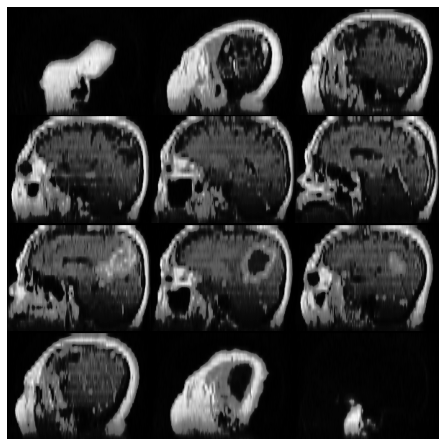

(200, 200, 150)

In [189]:
img = ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist_test/6_hist_fold_0/TCGA-06-0142/CT1.nii.gz')
ants.plot(img)
ants.image_write(img, 'CT1_hist.nii.gz')
img.shape

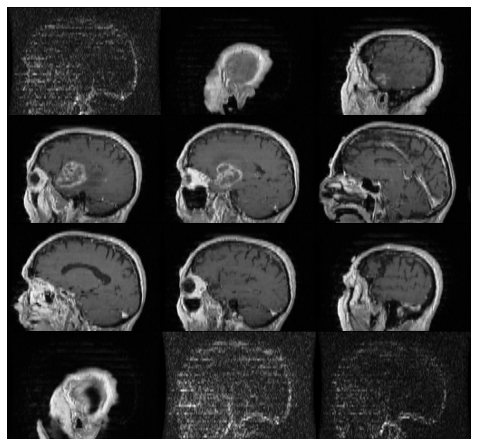

(240, 240, 168)

In [188]:
img = ants.image_read('/anvar/public_datasets/preproc_study/gbm/4a_resamp/TCGA-06-0142/CT1.nii.gz')
ants.plot(img)
ants.image_write(img, 'CT1_orig.nii.gz')
img.shape

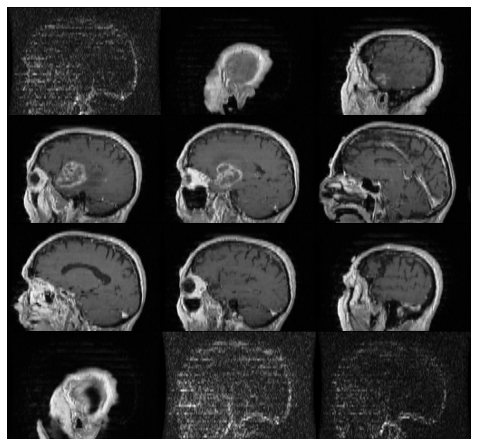

In [84]:
ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/gbm/4a_resamp/TCGA-06-0142/CT1.nii.gz'))

In [85]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_2/TCGA-06-0142/CT1_SEG.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 168)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-121.5, 109.6625, -92.1)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [156]:
ct1_hist = ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_0/TCGA-06-0142/CT1.nii.gz')
ct1 = ants.image_read('/anvar/public_datasets/preproc_study/gbm/4a_resamp/TCGA-06-0142/CT1.nii.gz')

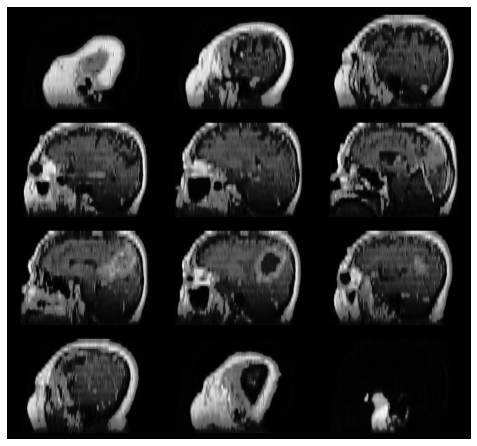

In [145]:
ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_2/TCGA-06-0142/CT1.nii.gz'))

In [143]:
from dpipe.im.visualize import slice3d

In [153]:
ct1_hist.numpy().shape, ct1.numpy().shape,

((200, 200, 150), (240, 240, 168))

In [158]:
slice3d(ct1_hist.numpy()- ct1.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=167), Output()), _dom…

In [155]:
slice3d(ct1.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=167), Output()), _dom…

In [134]:
import torchio as tio

file = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_2/TCGA-02-0037/FLAIR.nii.gz'
new = tio.ScalarImage(file)
old_shape = np.shape(
    ants.image_read('/anvar/public_datasets/preproc_study/gbm/4a_resamp/TCGA-02-0037/T1.nii.gz').numpy()
)
transform = tio.CropOrPad(old_shape)
transformed = transform(new)

transformed.save(file)

In [116]:
file = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_2/TCGA-06-0142/FLAIR.nii.gz'
ants.image_read(file)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 168)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-120.0, 122.3187, -62.5)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [89]:
transformed

ScalarImage(shape: (1, 240, 240, 168); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 36.9 MiB)

In [190]:
base_dir = '/anvar/public_datasets/preproc_study/gbm/4a_resamp/'
predicate_dir = '/anvar/public_datasets/preproc_study/gbm/3a_atlas/'
mask = 'CT1_SEG.nii.gz'
label = [0,1,2,3]

check_path(base_dir, predicate_dir, mask, label, check_pred = False)

  1%|          | 1/103 [00:02<04:52,  2.87s/it]

TCGA-02-0086 mask_GTV_FLAIR.nii.gz
File /anvar/public_datasets/preproc_study/gbm/4a_resamp//TCGA-02-0086/mask_GTV_FLAIR.nii.gz does not exist!


  2%|▏         | 2/103 [00:04<04:17,  2.55s/it]

TCGA-02-0102 mask_GTV_FLAIR.nii.gz
File /anvar/public_datasets/preproc_study/gbm/4a_resamp//TCGA-02-0102/mask_GTV_FLAIR.nii.gz does not exist!


  3%|▎         | 3/103 [00:06<04:00,  2.40s/it]

TCGA-02-0059 mask_GTV_FLAIR.nii.gz
File /anvar/public_datasets/preproc_study/gbm/4a_resamp//TCGA-02-0059/mask_GTV_FLAIR.nii.gz does not exist!


  3%|▎         | 3/103 [00:09<05:08,  3.09s/it]


KeyboardInterrupt: 

In [203]:
os.listdir('/anvar/public_datasets/preproc_study/bgpd/5_ss_shared/1360_18')

['T2.nii.gz',
 'FLAIR.nii.gz',
 'T1.nii.gz',
 'mask_GTV_FLAIR.nii.gz',
 'CT1.nii.gz',
 'FLAIR_mask.nii.gz']

In [211]:
ants.image_read(
    '/anvar/public_datasets/preproc_study/bgpd/1_reg/1360_18/T2.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 192)
	 Spacing    : (0.9766, 0.9766, 1.0)
	 Origin     : (-120.4874, 148.3726, -97.3931)
	 Direction  : [ 0.9974 -0.0715  0.0015 -0.0712 -0.9945 -0.077  -0.007  -0.0767  0.997 ]

In [207]:
ants.image_read(
    '/anvar/public_datasets/preproc_study/bgpd/5_ss_shared/1360_18/T2.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-119.0, 129.0, -68.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [208]:
ants.image_read(
    '/anvar/public_datasets/preproc_study/bgpd/4a_resamp/1360_18/T2.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (265, 265, 168)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-127.4183, 155.3809, -84.7808)
	 Direction  : [ 0.9974 -0.0715  0.0015 -0.0712 -0.9945 -0.077  -0.007  -0.0767  0.997 ]

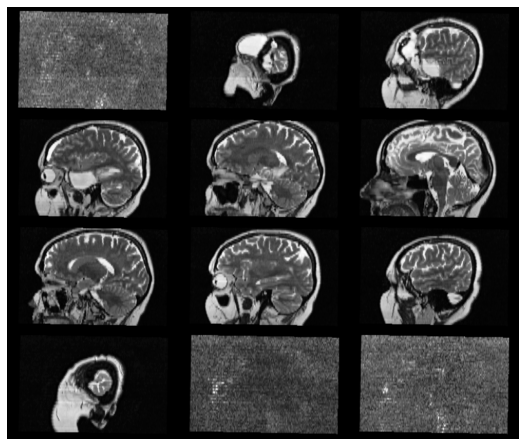

In [213]:
ants.plot(
    '/anvar/public_datasets/preproc_study/bgpd/4a_resamp/1360_18/T2.nii.gz')

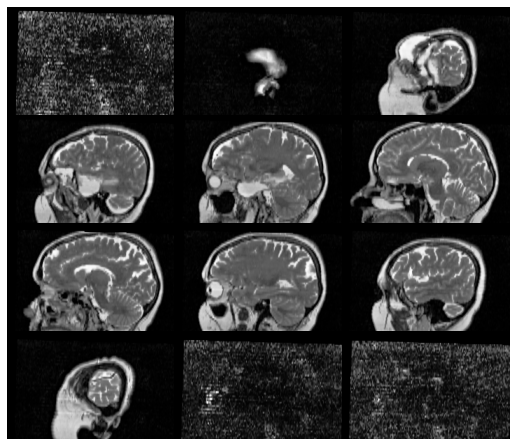

In [212]:
ants.plot(
    '/anvar/public_datasets/preproc_study/bgpd/6_hist/6_hist_fold_1/1360_18/T2.nii.gz')

In [201]:
base_dir = '/anvar/public_datasets/preproc_study/bgpd/5_ss_shared/'
predicate_dir = '/anvar/public_datasets/preproc_study/bgpd/3a_atlas/'
mask = 'mask_GTV_FLAIR.nii.gz'
label = [0,1]
check_path(base_dir, predicate_dir, mask, label, check_pred = True)

  0%|          | 0/181 [00:00<?, ?it/s]/tmp/ipykernel_3723231/3063816820.py:34: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.

  1%|          | 1/181 [00:02<06:37,  2.21s/it]

1360_18 mask_GTV_FLAIR.nii.gz
'bool' object has no attribute 'all'


  1%|          | 2/181 [00:04<06:30,  2.18s/it]

Patient_98817 mask_GTV_FLAIR.nii.gz
'bool' object has no attribute 'all'


  2%|▏         | 3/181 [00:06<06:23,  2.15s/it]

Patient_110816 mask_GTV_FLAIR.nii.gz
'bool' object has no attribute 'all'


  2%|▏         | 4/181 [00:08<06:15,  2.12s/it]

1421_18 mask_GTV_FLAIR.nii.gz
'bool' object has no attribute 'all'


  2%|▏         | 4/181 [00:10<07:53,  2.68s/it]


KeyboardInterrupt: 

In [175]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_0/TCGA-06-0142')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [53]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_0/TCGA-02-0086')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1.nii.gz']

In [ ]:
nohup python 5_ss.py --path /anvar/public_datasets/preproc_study/gbm/4a_resamp/ --output /mnt/public_data/preproc_study/gbm/5_ss_shared/ --device 0 &